In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("zadorlab/neural-tangent-ensemble")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

summary_df = pd.json_normalize(summary_list)

# Flatten the 'config' column
config_df = pd.json_normalize(config_list)

# Concatenate the flattened DataFrames along with the 'name' column
runs_df = pd.concat([summary_df, config_df], axis=1)
runs_df.head()

,_step,epoch,num_params,step,_runtime,_timestamp,train metrics.accuracy_2,train metrics.accuracy_3,train metrics.accuracy_4,train metrics.loss_1,...,optimizer.inv_temperature,optimizer.eta,optimizer.log_Z,optimizer.reg_method,ntk_use_current_grads,optimizer.epsilon,optimizer.b1,optimizer.b2,optimizer.eps,model.features
0,6102.0,1024.0,1796010.0,58.0,2754.699163,1.715140e+09,NaN,NaN,0.881836,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3054.0,516.0,1796010.0,117.0,1417.921180,1.715137e+09,NaN,NaN,0.857422,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1536.0,263.0,1796010.0,234.0,826.325107,1.715134e+09,NaN,NaN,0.792969,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,768.0,135.0,1796010.0,468.0,548.059928,1.715134e+09,NaN,NaN,0.726562,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,384.0,71.0,1796010.0,937.0,427.459585,1.715133e+09,NaN,NaN,0.421875,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# add number of parameters
runs_df['num_params'] = runs_df['model.features_per_layer'] * 785 + \
                        runs_df['model.features_per_layer'] * (runs_df['model.features_per_layer'] + 1) * (runs_df['model.nlayers'] - 1)\
                      + runs_df['model.nclasses'] * (runs_df['model.features_per_layer'] + 1)

In [17]:
runs_df[filter_][['num_params', 'model.features_per_layer', 'model.nlayers', 'model.nclasses', 'optimizer.eta', 'optimizer.inv_temperature', 'optimizer.max_delta', 'test metrics.accuracy_0']]

,num_params,model.features_per_layer,model.nlayers,model.nclasses,optimizer.eta,optimizer.inv_temperature,optimizer.max_delta,test metrics.accuracy_0
5,1796010.0,1000.0,2.0,10,NaN,0.01,0.1,0.800919
7,1796010.0,1000.0,2.0,10,NaN,0.01,0.1,0.815400
10,1796010.0,1000.0,2.0,10,NaN,0.01,0.1,0.813700
13,1796010.0,1000.0,2.0,10,NaN,0.01,0.1,0.816837
15,1796010.0,1000.0,2.0,10,NaN,0.01,0.1,0.800700
24,1796010.0,1000.0,2.0,10,0.1,0.01,NaN,0.887528
25,1796010.0,1000.0,2.0,10,0.1,0.01,NaN,0.879642
26,1796010.0,1000.0,2.0,10,0.1,0.01,NaN,0.879492
27,1796010.0,1000.0,2.0,10,0.1,0.01,NaN,0.873714
28,1796010.0,1000.0,2.0,10,0.1,0.01,NaN,0.872611


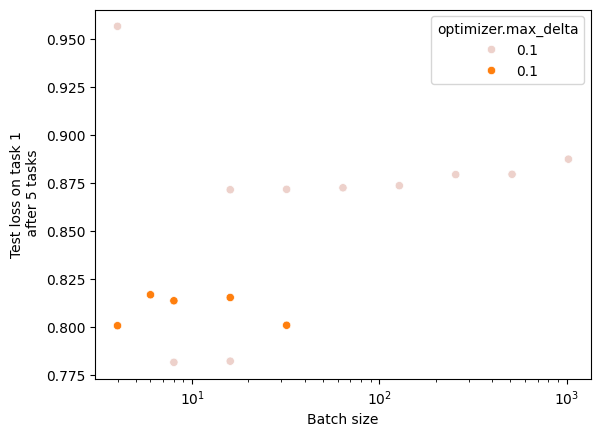

Text(0, 0.5, 'Test loss on task 1\n after 1 tasks')

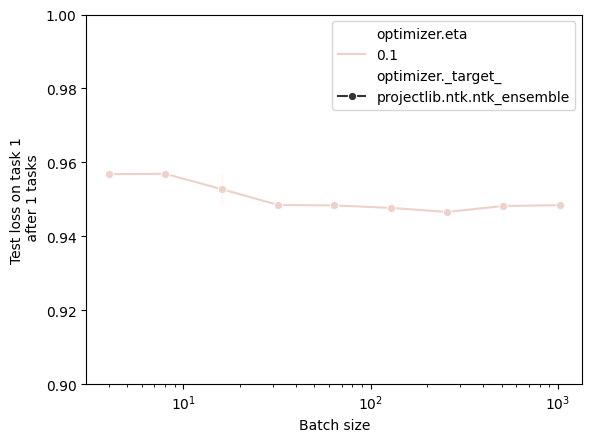

In [14]:

filter_ = runs_df['logger.tags'].isin(['bs_exp']) & (runs_df['optimizer._target_']!='optax.sgd')

g=sns.scatterplot(data=runs_df[filter_], x='data.batchsize',y='test metrics.accuracy_0',hue='optimizer.eta', markers=True,)
g=sns.scatterplot(data=runs_df[filter_], x='data.batchsize',y='test metrics.accuracy_0',style='optimizer.max_delta', markers=True,)
plt.legend(['eta','max_delta'
])
plt.xscale('log')
plt.xlabel('Batch size')
plt.ylabel('Test loss on task 1\n after 5 tasks')
plt.show()
g=sns.lineplot(data=runs_df[filter_], x='data.batchsize',y='single_task.accuracy_0',hue='optimizer.eta', markers=True, style='optimizer._target_')
plt.xscale('log')
plt.ylim(.9,1)
plt.xlabel('Batch size')
plt.ylabel('Test loss on task 1\n after 1 tasks')

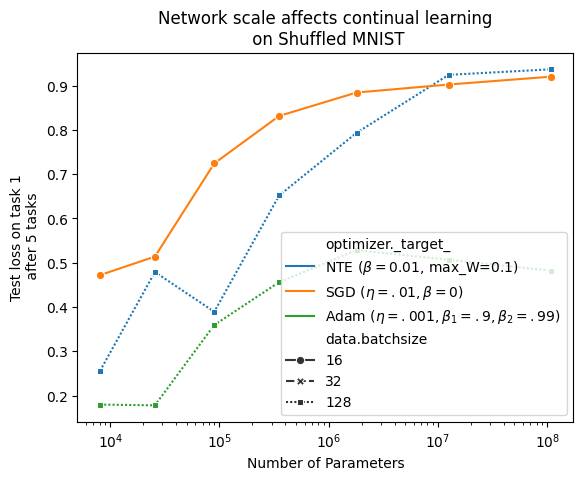

In [78]:

filter_ = np.isnan(runs_df['optimizer.epsilon']) & (runs_df['ntasks']==5)  &  (runs_df['optimizer.momentum'] != 0.9) & runs_df[filter_]['logger.tags'].isna()

g=sns.lineplot(data=runs_df[filter_], x='num_params',y='test metrics.accuracy_0',hue='optimizer._target_', markers=True, style='data.batchsize')
plt.xscale('log')
plt.xlabel('Number of Parameters')
plt.ylabel('Test loss on task 1\n after 5 tasks')
plt.title("Network scale affects continual learning\n on Shuffled MNIST")
new_labels ={'sgd':r"SGD ($\eta=.01, \beta=0$)",
              'nte': r"NTE ($\beta=0.01$, max_W=0.1)", 
              'adam':r'Adam ($\eta=.001, \beta_1=.9, \beta_2=.99$)'}

g.legend()
for t in g.legend_.texts:
#     t.set_text(l)
    if 'sgd' in t.get_text():
        t.set_text(new_labels['sgd'])
    elif 'ens' in t.get_text():
        t.set_text(new_labels['nte'])
    elif 'adam' in t.get_text():
        t.set_text(new_labels['adam'])

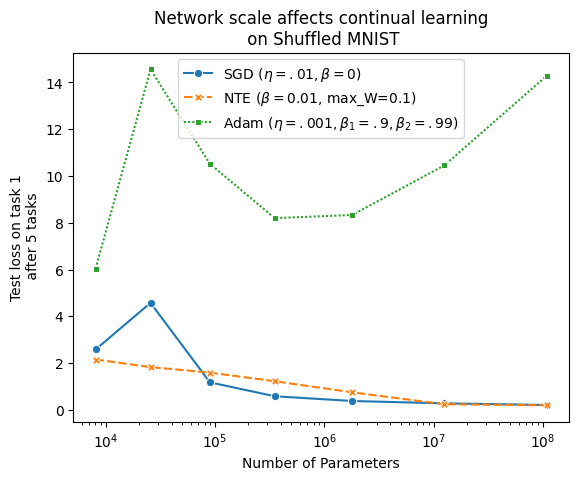

In [80]:

filter_ = np.isnan(runs_df['optimizer.epsilon']) & (runs_df['ntasks']==5)  & (runs_df['ntasks']==5)  * (runs_df['optimizer.momentum'] != 0.9)

g=sns.lineplot(data=runs_df[filter_], x='num_params',y='test metrics.loss_0',hue='optimizer._target_', markers=True, style='optimizer._target_')
plt.xscale('log')
plt.xlabel('Number of Parameters')
plt.ylabel('Test loss on task 1\n after 5 tasks')
plt.title("Network scale affects continual learning\n on Shuffled MNIST")
new_labels ={'sgd':r"SGD ($\eta=.01, \beta=0$)",
              'nte': r"NTE ($\beta=0.01$, max_W=0.1)", 
              'adam':r'Adam ($\eta=.001, \beta_1=.9, \beta_2=.99$)'}

g.legend()
for t in g.legend_.texts:
#     t.set_text(l)
    if 'sgd' in t.get_text():
        t.set_text(new_labels['sgd'])
    elif 'ens' in t.get_text():
        t.set_text(new_labels['nte'])
    elif 'adam' in t.get_text():
        t.set_text(new_labels['adam'])

## The adaptive temperature experiment failed

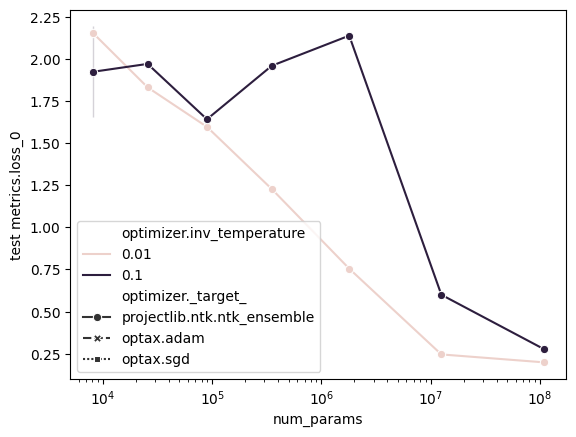

In [22]:
sns.lineplot(data=runs_df, x='num_params',y='test metrics.loss_0',hue='optimizer.inv_temperature', markers=True, style='optimizer._target_')
plt.xscale('log')
